# LAB 1: Metric Algorithms
### AI and Machine Learning // Suchkova Natalia М8О - 114М - 22
17.03.23 @ MAI IT-Center

## The Task
1. Применить метод K ближайших соседей  (KNN ядерный), взвешенный алгоритмом STOLP для пяти классов, сгенерированных с помощью MakeClassification

2. (*) Для сгенерированного датасета, сгенерировать профиль компактности

3. Для сгенерированного датасета, произвести оптимизацию по выбору ширины окна (или метод меняющегося окна)

4. Найти датасет с картинками (2-3 класса) небольшой (100 картинок достаточно, классифицированных). Найти метод\библиотеку для построения embedding (векторизации) изображений. Применить этот метод на картинки. Применить КNN (без оптимизации) для полученного датасета из векторизванных картинок.

5. (*) Задание 4 со своими фотографиями.

## Table of Contents


1. [**Chosen Functions' Formulas**](#g5)


2. [**Functions' Visualization**](#g4)

    - [Himmelblau Function](#g4)
    
    - [Rastrigin Function](#g3)
    
    - [Rosenbrock Function](#g2)


3. [**Classical Gradient Descent**](#g1)

    - [For Himmelblau](#g6)
    
    - [For Rastrigin](#g7)
    
    - [For Rosenbrock](#g8)
    
    
4. [**Classical GD with Data Blobs**](#g10)
    
    - [Loss Function & Data Generation](#g10)


5. [**Сlassical Stochastic Gradient Descent**](#g9)
    
    - [SGD Method Code](#g11)
    
    - [SGD w/ Data Blobs](#g90)
    

## Задание 1.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors


from scipy.spatial import KDTree

In [56]:
seed = np.random.seed(11)

#### Генерим данные

In [57]:
X, Y = make_classification(n_samples=1000, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=seed)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    random_state=seed)

#### KNN

In [58]:
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=6)

In [59]:
predictions = model.predict(X_test)

In [60]:
def plot(data, preds):
    colors = [np.array([1, 0, 0]).reshape(1, -1), 
              np.array([0, 1, 0]).reshape(1, -1), 
              np.array([0, 0, 1]).reshape(1, -1),
              np.array([1, 1, 0]).reshape(1, -1), 
              np.array([1, 0, 1]).reshape(1, -1)
             ] # распределение цветов по классам
    c = [colors[i] for i in preds] # распределение цветов по классам
    fig = plt.figure()
    ax = fig.add_subplot(111, 
                         projection='3d'
                        )
    ax.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c) # изображаем классификацию
    plt.show()
    
    
def plot_compare(data, labels, lbl_preds):
    colors = [np.array([1, 0, 0]).reshape(1, -1), 
              np.array([0, 1, 0]).reshape(1, -1), 
              np.array([0, 0, 1]).reshape(1, -1),
              np.array([1, 1, 0]).reshape(1, -1), 
              np.array([1, 0, 1]).reshape(1, -1)
             ]
    
    fig = plt.figure(figsize=plt.figaspect(0.6))
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title('Реальные значения')
    c = [colors[i] for i in labels]
    ax1.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c)

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title('Наши предсказания')
    c = [colors[i] for i in lbl_preds]
    ax2.scatter(data[ : , 0], 
               data[ : , 1], 
               data[ : , 2], 
               c=c)
    

    
    plt.show()
    
    
# def plot(n_samples, data, preds):
#     colors = [np.array([1, 0, 0]).reshape(1,-1), 
#               np.array([0, 1, 0]).reshape(1, -1), 
#               np.array([0, 0, 1]).reshape(1, -1),
#               np.array([1, 1, 0]).reshape(1, -1), 
#               np.array([1, 0, 1]).reshape(1, -1)
#              ] # распределение цветов по классам
#     c = [colors[i] for i in preds[ :n_samples]] # распределение цветов по классам
#     fig = plt.figure()
#     ax = fig.add_subplot(111, 
#                          projection='3d'
#                         )
#     ax.scatter(data[ :n_samples, 0], 
#                data[ :n_samples, 1], 
#                data[ :n_samples, 2], 
#                c=c) # изображаем классификацию
#     plt.show()

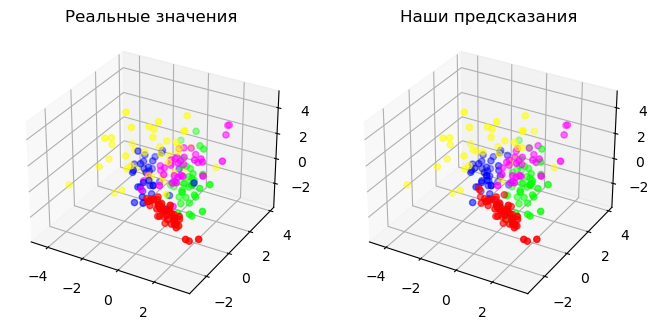

In [61]:
plot_compare(X_test, Y_test, predictions)

In [62]:
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90        45
           1       0.81      0.85      0.83        41
           2       0.65      0.76      0.70        34
           3       0.86      0.72      0.78        43
           4       0.90      0.73      0.81        37

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.82      0.81      0.81       200



#### STOLP  
— алгоритм отбора эталонных объектов для метрического классификатора.

Пусть дана обучающая выборка $X^l=(x_i, y_i)_{i=1}^l$, где $x_i$ — объекты, $y_i=y^*(x_i)$ — классы, которым принадлежат эти объекты. 

Кроме того, задана метрика $\rho \: X \times X \rightarrow \mathbb{R}$, такая, что выполняется гипотеза компактности. 

При классификации объектов метрическим классификатором $$a(u, X^l) = \mathrm{arg}\max_{y\in Y} \Gamma_y (u, X^l) = \mathrm{arg}\max_{y\in Y} \sum_{i=1}^l[y_u^(i)=y]w(i, u),$$ например, `методом ближайших соседей` необходимо вычислять расстояния от классифицируемого объекта до всех объектов обучающей выборки. 

Минусы: Время, затрачиваемое на это для каждого классифицируемого объекта, пропорционально размеру обучающей выборки. Кроме того, оказывается необходимым хранить большой объем данных.

Но не все объекты обучающей выборки равноценны. 

Среди них есть
- наиболее типичные представители классов, то есть **эталоны**; 
- **неинформативные объекты**, при удалении которых из обучающей выборки качество классификации не изменится;
- **выбросы, или шумовые объекты** — объекты, находящиеся в гуще «чужого» класса, только ухудшающие качество классификации.

Поэтому необходимо уменьшить объем обучающей выборки, оставив в ней только эталонные объекты для каждого класса.

**Oтступ (margin)** показывает насколько истинный класс далеко от другого класса. Отступ объекта показывает нам, насколько глубоко текущий объект лежит в пределах своего класса. Например, если почти все ближайшие соседи некоторого объекта x_i принадлежат к тому же классу, что и сам x_i, мы можем сказать, что у него очень положительный отступ. С другой стороны, если почти все ближайшие соседи принадлежат к другому классу, чем x_i, отступ должен быть отрицательным. Мы можем вычислить маржу таким образом: в случае, если отступ положительный, то предсказание является верным. В случае, если отступ отрицательный, то предсказание является ошибочным.

Но для начала нужно сделать несколько шагов:

1. Для каждого элемента выборки найти сумму евклидового расстояния до ближайших n соседей;

2. Отсортировать элементы выборки по сумме расстояний;

3. Взять первые N элементов - они и будут эталонными объектами.

https://jet1black.wordpress.com/2015/10/03/stolp-algorithm-implementation/

In [63]:
def generate_normal(x, y, items_num):
    x = [np.random.normal() * 3 + x for i in range(items_num)]  # scale random distribution by 3
    y = [np.random.normal() * 3 + y for i in range(items_num)]
    return x, y

In [13]:
def generate_dataset():
    a = generate_normal(0, 0, 200)
    b = generate_normal(8, 8, 200)
    y1 = [1] * len(a[0])
    y2 = [-1] * len(b[0])
    x = np.concatenate((np.array(a).transpose(), np.array(b).transpose()), axis=0)
    y = np.array([y1 + y2]).transpose()
    return x, y

In [14]:
x, y = generate_dataset()

In [45]:
import numpy as np
from sklearn.neighbors import KDTree
rng = np.random.RandomState(0)
X = rng.random_sample((10, 3))  # 10 points in 3 dimensions
tree = KDTree(X)              
q = tree.query(X[4:6], k=3)                
# print(ind)  # indices of 3 closest neighbors
# print(dist)  # distances to 3 closest neighbors
q[1]

array([[4, 3, 8],
       [5, 1, 7]], dtype=int64)

In [69]:
def classify(x, y, u, n):
    xkd = KDTree(x)
    result = []
    bound = min(n, x.shape[0])
    for cur_i, cur_u in enumerate(u):
        print(cur_u)
        idx = xkd.query(cur_u.reshape(1, -1), bound)[1]
        maj = {}
        for i in idx:
            y_cur = y[i, 0]
            di = np.linalg.norm(cur_u - x[i])
            dn = np.linalg.norm(cur_u - x[idx[bound - 1]])
            w = 0.0
            if di != 0.0 and dn > di:
                w = dn / di
            maj[y_cur] = maj.get(y_cur, 0) + w
        ans = sorted(maj.items(), key=lambda x: x[1])[-1][0]
        result.append(ans)
    return np.array(result)

In [70]:
classify(x, y, x, 3)

[ 1.97860137 -8.42874936]


IndexError: index 2 is out of bounds for axis 0 with size 1

In [253]:
predictions

array([1, 1, 0, 0, 0, 2, 3, 2, 3, 4, 2, 2, 0, 0, 1, 4, 2, 3, 3, 3, 1, 1,
       1, 0, 0, 1, 4, 0, 3, 4, 0, 4, 2, 3, 3, 3, 4, 0, 0, 1, 3, 2, 3, 4,
       0, 2, 3, 2, 4, 1, 2, 4, 1, 1, 2, 0, 2, 0, 0, 4, 3, 3, 1, 1, 0, 3,
       0, 1, 2, 3, 1, 0, 3, 2, 3, 4, 1, 0, 0, 1, 2, 4, 0, 0, 2, 3, 1, 1,
       1, 3, 1, 4, 3, 2, 2, 4, 1, 0, 4, 2, 3, 2, 2, 2, 1, 0, 2, 1, 0, 3,
       4, 3, 4, 0, 3, 4, 0, 3, 3, 2, 2, 0, 2, 0, 3, 1, 1, 4, 0, 1, 0, 1,
       1, 2, 1, 3, 2, 2, 2, 1, 3, 0, 2, 0, 1, 1, 0, 0, 0, 1, 4, 3, 3, 0,
       1, 0, 3, 1, 4, 1, 0, 1, 4, 2, 3, 3, 3, 3, 0, 2, 1, 1, 0, 0, 4, 0,
       0, 3, 1, 1, 4, 3, 0, 3, 3, 4, 4, 3, 3, 1, 0, 2, 4, 0, 4, 0, 4, 3,
       1, 3])

In [64]:
def compute_margins(xkd, x, y, u, u_ans, n):
    result = []
    bound = min(n, y.shape[0]) # задаем количество ближайших соседей для исследования
    
    for cur_u_idx, cur_u_coord in enumerate(u):  # задаем индекс каждой точке в u
        idx = xkd.query(cur_u_coord, bound)[1]  # сохраняем индексы ближайших соседей
        maj = {}
        
        for i in idx:
            y_cur = y[i]  # перебираем все класс в ближайших соседях по их индексу
            di = np.linalg.norm(cur_u_coord - x[i])  # расстояние от текущей точки до каждой точки в данных
            dn = np.linalg.norm(cur_u_coord - x[idx[bound - 1]])  # расстояние от текущей точки до предыдущей из n соседей
            w = 0.0
            
            if di != 0.0 and dn > di:
                w = dn / di
                
            maj[y_cur] = maj.get(y_cur, 0) + w  # обновляем в словаре по индексу точки ее вес, 
                                                # если новая точка, то ее вес 0 сначала
            
        cur_u_ans = u_ans[cur_u_idx] # находим в Y_train по текущему индексу класс [u_ans[cur_u_idx]][0]
        correct_score = maj.get(cur_u_ans, 0)  # достаем из словаря вес точки
        del maj[cur_u_ans]
        
        max_wrong = 0
        if len(maj) > 0:
            max_wrong = sorted(maj.items(), key=lambda x: x[1])[-1][1] # находим максимально отдаленный элемент (точку)
            
        result.append(correct_score - max_wrong)  # для рассчета конечной удаленности вычитаем самый большой отступ
        
    return np.array(result)

In [65]:
# def compute_margins(xkd, x, y, u, u_ans, n):  мы считаем отступ для всех точек, поэтому у нас х и и это одно и то же
margins = compute_margins(KDTree(X_test), X_test, Y_test, X_test, Y_test, 5)

In [66]:
len(margins)

200

In [91]:
def stolp(src_x, src_y, err_num, depth_limit, n):
    #Step 2
    support_x = []
    support_y = []
    src_xkd = KDTree(src_x)
    margins = np.array([compute_margins(src_xkd, src_x, src_y, src_x, src_y, n)]).transpose()
    #Step 3
    x = src_x[margins[:, 0] > depth_limit]
    y = src_y[margins[:, 0] > depth_limit]
    print(len(x), len(y))
    margins = margins[margins[:, 0] > depth_limit]
    ss = np.argsort(margins[:, 0])
    #Step 4
    for ans in np.unique(y):
        for m in ss:
            if y[m] == ans:
                support_x.append(x[m])
                support_y.append(y[m])
                x = np.delete(x, (m), axis=0)
                y = np.delete(y, (m), axis=0)
                break
    errors = x.shape[0]
    
    #Step 5
    while errors > err_num:
        xkd = KDTree(np.array(support_x))
        margins = compute_margins(xkd, np.array(support_x), np.array(support_y), x, y, n)
        KNN_preds = model.predict(support_x)
        print(KNN_preds, src_y)
#         errors = sum(KNN_preds != src_y)
        errors = len(KNN_preds[KNN_preds == src_y[:len(KNN_preds)]])
        print('errors', errors, err_num)
        sorted_margs = np.argsort(margins)  # выводим индексы отсортированных отступов
        to_delete = []
        min = sorted_margs[0]
        support_x.append(x[min])
        support_y.append(y[min])
        to_delete.append(min)
        print(min, to_delete)
        x = np.delete(x, to_delete, axis=0)
        y = np.delete(y, to_delete, axis=0)
    return np.array(support_x), np.array(support_y)


In [90]:
a = np.array([1,2,3,4,5,6])
b = np.array([1,4,3, 4])
# print(np.intersect1d(a, b))
a[a==b]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


array([], shape=(0, 6), dtype=int32)

In [97]:
stolp_prx, stolp_pry = stolp(X_test, Y_test, 3, -1, 10)

160 160
[0 1 2 2 4] [1 1 0 4 0 3 4 2 3 4 1 2 0 0 1 3 1 3 3 3 1 1 1 0 0 1 2 0 3 4 0 3 3 3 4 4 4
 0 0 1 4 2 3 4 0 3 3 2 4 4 2 4 1 2 2 0 2 0 0 3 3 2 1 1 0 3 0 1 2 3 1 0 3 3
 3 4 1 0 0 1 3 4 0 4 2 3 1 1 1 3 1 4 1 4 2 4 1 1 2 2 3 2 2 0 1 2 4 1 4 3 4
 3 4 3 4 4 0 3 3 2 2 0 2 0 3 1 1 4 0 1 0 1 1 2 3 3 2 2 4 1 4 0 0 0 1 1 0 0
 0 1 4 3 3 0 3 0 3 2 4 1 0 2 4 2 2 4 3 3 0 2 1 1 0 0 4 0 0 2 0 1 4 3 0 2 2
 4 4 3 3 1 0 2 4 0 4 0 2 3 1 3]
errors 1 3
106 [106]


array([[-0.39755022, -0.1927254 , -1.49253476],
       [-1.04188742,  3.56173978,  0.15366528],
       [-1.57243702,  2.06213663, -0.22843579],
       [-1.08571956,  0.91605039, -1.04686264],
       [-0.2210118 ,  2.11178917,  0.92071537],
       [-1.03207399,  0.78867884, -1.31657023]])

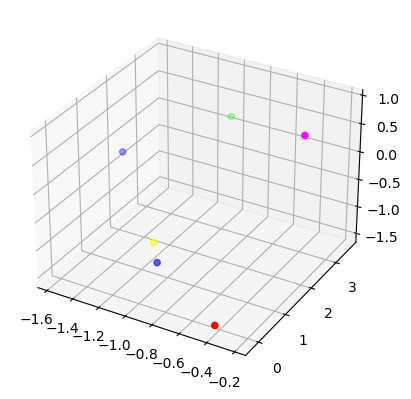

In [100]:
plot(stolp_prx, stolp_pry)

In [ ]:
def scores(self, X):
    features = self.gams*self.kernel(cdist(X, self.X))
    #print(self.kernel(cdist(X, self.X)))
    scores = np.vstack(
        [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1),
         np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1)]).T
    return scores

In [ ]:
neighbours_0, neighbours_1, neighbours_2, neighbours_3, neighbours_4 = [], [], [], [], []
# Разделим элементы по классам
for i in range(200):
    if Y_train[i] == 0:
        neighbours_0 = np.append(neighbours_0, X_train[i])
    elif Y_train[i] == 1:
        neighbours_1 = np.append(neighbours_1, X_train[i])
    elif Y_train[i] == 2:
        neighbours_2 = np.append(neighbours_2, X_train[i])
    elif Y_train[i] == 3:
        neighbours_3 = np.append(neighbours_3, X_train[i])
    else:
        neighbours_4 = np.append(neighbours_4, X_train[i])
        
        
neighbours_0 = np.reshape(neighbours_0, (-1,3))
neighbours_1 = np.reshape(neighbours_1, (-1,3)) 
neighbours_2 = np.reshape(neighbours_2, (-1,3)) 
neighbours_3 = np.reshape(neighbours_3, (-1,3)) 
neighbours_4 = np.reshape(neighbours_4, (-1,3)) 

In [ ]:
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(neighbours_0)

#for i in range(len(neighbours_0)):
#    print(neigh.kneighbors([X_train[i]]))

ed_sums_0 = np.zeros(len(neighbours_0))
for i in range(len(neighbours_0)):
    ed_sums_0[i] = np.sum(neigh.kneighbors([neighbours_0[i]])[0]) # суммы евклидовых расстояний
print("Sums of distances [CLASS 0]: \n", ed_sums_0)
np.sort(ed_sums_0) # Сортируем по минимуму
print("SORTED Sums of distances [CLASS 0]: \n",ed_sums_0)
eds_indices_0 = np.argsort(ed_sums_0) # Индексы отсортированного массива
print("INDICES OF SORTED Sums of distances [CLASS 0]: \n", eds_indices_0)

#### Parzen Window Method

In [ ]:
def ParzRos_score(x: float, h: float, data: np.array, kernel: Mapping, distance: Mapping) -> float:
    """
    Function: 
        Метод возвращает значение, найденное методом Парзена-Розенблатта для группы точек.

    Args: 
        x: float - параметр функции ядра.
        h: float - параметр метода Парзена-Розенблатта: ширина окна.
        data: list или array - набор точек.
        kernel: Mapping - тип ядра.
        distance: Mapping - функция расчета расстояния между двумя точками 
                        на плоскости или в пространстве (для нелинейной задачи).

    Return:
        Значение найденное методом Парзена-Розенблатта для группы точек (float).
    """
    return sum([kernel(distance(x, point) / h) for point in data]) / (len(data) * h)